In [1]:
import os

In [2]:
pip install yellowbrick

Note: you may need to restart the kernel to use updated packages.


In [3]:
import numpy as np
import pandas as pd
import warnings
import sys
if not sys.warnoptions:
    warnings.simplefilter("ignore")
np.random.seed(1234)
import datetime
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.colors import ListedColormap
from mpl_toolkits.mplot3d import Axes3D

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler



In [4]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer

# EDA

In [5]:
df=pd.read_csv("marketing_campaign.csv")

In [6]:
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


In [7]:
df.shape

(2240, 29)

In [8]:
#Information on features 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

In [9]:
#To remove the NA values
df= df.dropna()
print("The total number of data-points after removing the rows with missing values are:", len(df))

The total number of data-points after removing the rows with missing values are: 2216


# Feature Engineering and Data Cleaning

In [10]:
df["Dt_Customer"] = pd.to_datetime(df["Dt_Customer"])
dates = []
for i in df["Dt_Customer"]:
    i = i.date()
    dates.append(i)  
#Dates of the newest and oldest recorded customer
print("The newest customer's enrolment date in therecords:",max(dates))
print("The oldest customer's enrolment date in the records:",min(dates))

The newest customer's enrolment date in therecords: 2014-12-06
The oldest customer's enrolment date in the records: 2012-01-08


Creating a feature ("Customer_For") of the number of days the customers started to shop in the store relative to the last recorded date

In [11]:
#Created a feature "Customer_For"
days = []
d1 = max(dates) #taking it to be the newest customer
for i in dates:
    delta = d1 - i
    days.append(delta)
df["Customer_For"] = days
df["Customer_For"] = pd.to_numeric(df["Customer_For"], errors="coerce")

Now we will be exploring the unique values in the categorical features to get a clear idea of the data.

In [12]:
print("Total categories in the feature Marital_Status:\n", df["Marital_Status"].value_counts(), "\n")

Total categories in the feature Marital_Status:
 Married     857
Together    573
Single      471
Divorced    232
Widow        76
Alone         3
Absurd        2
YOLO          2
Name: Marital_Status, dtype: int64 



In [13]:
print("Total categories in the feature Education:\n", df["Education"].value_counts())

Total categories in the feature Education:
 Graduation    1116
PhD            481
Master         365
2n Cycle       200
Basic           54
Name: Education, dtype: int64


In [14]:
#Feature Engineering

#Age of customer today 
df["Age"] = 2023-df["Year_Birth"]

#Total spendings on various items
df["Spent"] = df["MntWines"]+ df["MntFruits"]+ df["MntMeatProducts"]+ df["MntFishProducts"]+ df["MntSweetProducts"]+ df["MntGoldProds"]

#Deriving living situation by marital status"Alone"
df["Living_With"]=df["Marital_Status"].replace({"Married":"Partner", "Together":"Partner", "Absurd":"Alone", "Widow":"Alone", "YOLO":"Alone", "Divorced":"Alone", "Single":"Alone",})

#Feature indicating total children living in the household
df["Children"]=df["Kidhome"]+df["Teenhome"]

#Feature for total members in the householde
df["Family_Size"] = df["Living_With"].replace({"Alone": 1, "Partner":2})+ df["Children"]

#Feature pertaining parenthood
df["Is_Parent"] = np.where(df.Children> 0, 1, 0)

#Segmenting education levels in three groups
df["Education"]=df["Education"].replace({"Basic":"Undergraduate","2n Cycle":"Undergraduate", "Graduation":"Graduate", "Master":"Postgraduate", "PhD":"Postgraduate"})

#For clarity
df=df.rename(columns={"MntWines": "Wines","MntFruits":"Fruits","MntMeatProducts":"Meat","MntFishProducts":"Fish","MntSweetProducts":"Sweets","MntGoldProds":"Gold"})

#Dropping some of the redundant features
to_drop = ["Marital_Status", "Dt_Customer", "Z_CostContact", "Z_Revenue", "Year_Birth", "ID"]
df = df.drop(to_drop, axis=1)

In [15]:
df.head(10)

,Education,Income,Kidhome,Teenhome,Recency,Wines,Fruits,Meat,Fish,Sweets,...,AcceptedCmp2,Complain,Response,Customer_For,Age,Spent,Living_With,Children,Family_Size,Is_Parent
0,Graduate,58138.0,0,0,58,635,88,546,172,88,...,0,0,1,83894400000000000,66,1617,Alone,0,1,0
1,Graduate,46344.0,1,1,38,11,1,6,2,1,...,0,0,0,10800000000000000,69,27,Alone,2,3,1
2,Graduate,71613.0,0,0,26,426,49,127,111,21,...,0,0,0,40780800000000000,58,776,Partner,0,2,0
3,Graduate,26646.0,1,0,26,11,4,20,10,3,...,0,0,0,5616000000000000,39,53,Partner,1,3,1
4,Postgraduate,58293.0,1,0,94,173,43,118,46,27,...,0,0,0,27734400000000000,42,422,Partner,1,3,1
5,Postgraduate,62513.0,0,1,16,520,42,98,0,42,...,0,0,0,39139200000000000,56,716,Partner,1,3,1
6,Graduate,55635.0,0,1,34,235,65,164,50,49,...,0,0,0,65059200000000000,52,590,Alone,1,2,1
7,Postgraduate,33454.0,1,0,32,76,10,56,3,1,...,0,0,0,42163200000000000,38,169,Partner,1,3,1
8,Postgraduate,30351.0,1,0,19,14,0,24,3,3,...,0,0,1,47347200000000000,49,46,Partner,1,3,1
9,Postgraduate,5648.0,1,1,68,28,0,6,1,1,...,0,0,0,23155200000000000,73,49,Partner,2,4,1


In [16]:
df.describe()

,Income,Kidhome,Teenhome,Recency,Wines,Fruits,Meat,Fish,Sweets,Gold,...,AcceptedCmp1,AcceptedCmp2,Complain,Response,Customer_For,Age,Spent,Children,Family_Size,Is_Parent
count,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,...,2216.000000,2216.000000,2216.000000,2216.000000,2.216000e+03,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000
mean,52247.251354,0.441787,0.505415,49.012635,305.091606,26.356047,166.995939,37.637635,27.028881,43.965253,...,0.064079,0.013538,0.009477,0.150271,4.423735e+16,54.179603,607.075361,0.947202,2.592509,0.714350
std,25173.076661,0.536896,0.544181,28.948352,337.327920,39.793917,224.283273,54.752082,41.072046,51.815414,...,0.244950,0.115588,0.096907,0.357417,2.008532e+16,11.985554,602.900476,0.749062,0.905722,0.451825
min,1730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000e+00,27.000000,5.000000,0.000000,1.000000,0.000000
25%,35303.000000,0.000000,0.000000,24.000000,24.000000,2.000000,16.000000,3.000000,1.000000,9.000000,...,0.000000,0.000000,0.000000,0.000000,2.937600e+16,46.000000,69.000000,0.000000,2.000000,0.000000
50%,51381.500000,0.000000,0.000000,49.000000,174.500000,8.000000,68.000000,12.000000,8.000000,24.500000,...,0.000000,0.000000,0.000000,0.000000,4.432320e+16,53.000000,396.500000,1.000000,3.000000,1.000000
75%,68522.000000,1.000000,1.000000,74.000000,505.000000,33.000000,232.250000,50.000000,33.000000,56.000000,...,0.000000,0.000000,0.000000,0.000000,5.927040e+16,64.000000,1048.000000,1.000000,3.000000,1.000000
max,666666.000000,2.000000,2.000000,99.000000,1493.000000,199.000000,1725.000000,259.000000,262.000000,321.000000,...,1.000000,1.000000,1.000000,1.000000,9.184320e+16,130.000000,2525.000000,3.000000,5.000000,1.000000


Reletive Plot Of Some Selected Features: A Data Subset


<Figure size 800x550 with 0 Axes>

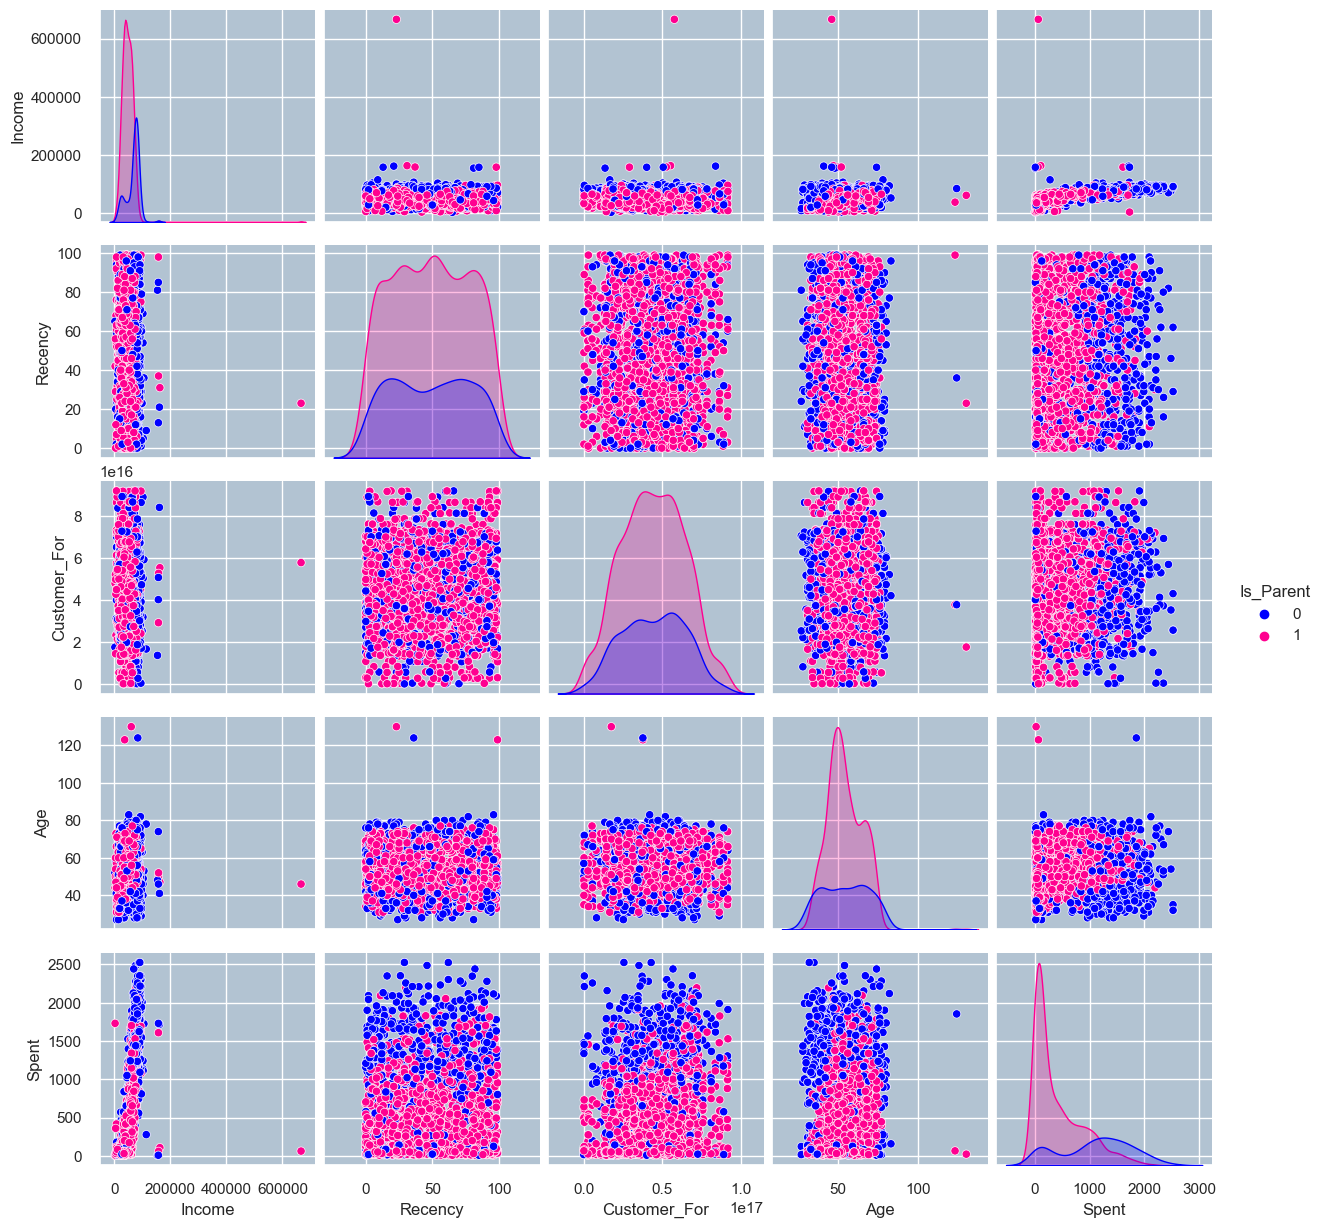

In [17]:
#To plot some selected features 

#Setting up colors prefrences
sns.set(rc={"axes.facecolor":"#B2C3D2","figure.facecolor":"#FFFFFF"})

pallet = ["#0000FF", "#E6E6FA", "#7FFF00", "#00FF00", "#FFF200", "#F3AB60"]
cmap = colors.ListedColormap(["#0000FF", "#E6E6FA", "#7FFF00", "#00FF00", "#FFF200", "#F3AB60"])

#Plotting following features
To_Plot = [ "Income", "Recency", "Customer_For", "Age", "Spent", "Is_Parent"]
print("Reletive Plot Of Some Selected Features: A Data Subset")

plt.figure()
sns.pairplot(df[To_Plot], hue= "Is_Parent",palette= (["#0000FF","#FF0090"]))
#Taking hue 
plt.show()

In [18]:
#Dropping the outliers by setting a cap on Age and income. 
df = df[(df["Age"]<90)]
df = df[(df["Income"]<600000)]
print("The total number of data-points after removing the outliers are:", len(df))

The total number of data-points after removing the outliers are: 2212


<AxesSubplot:>

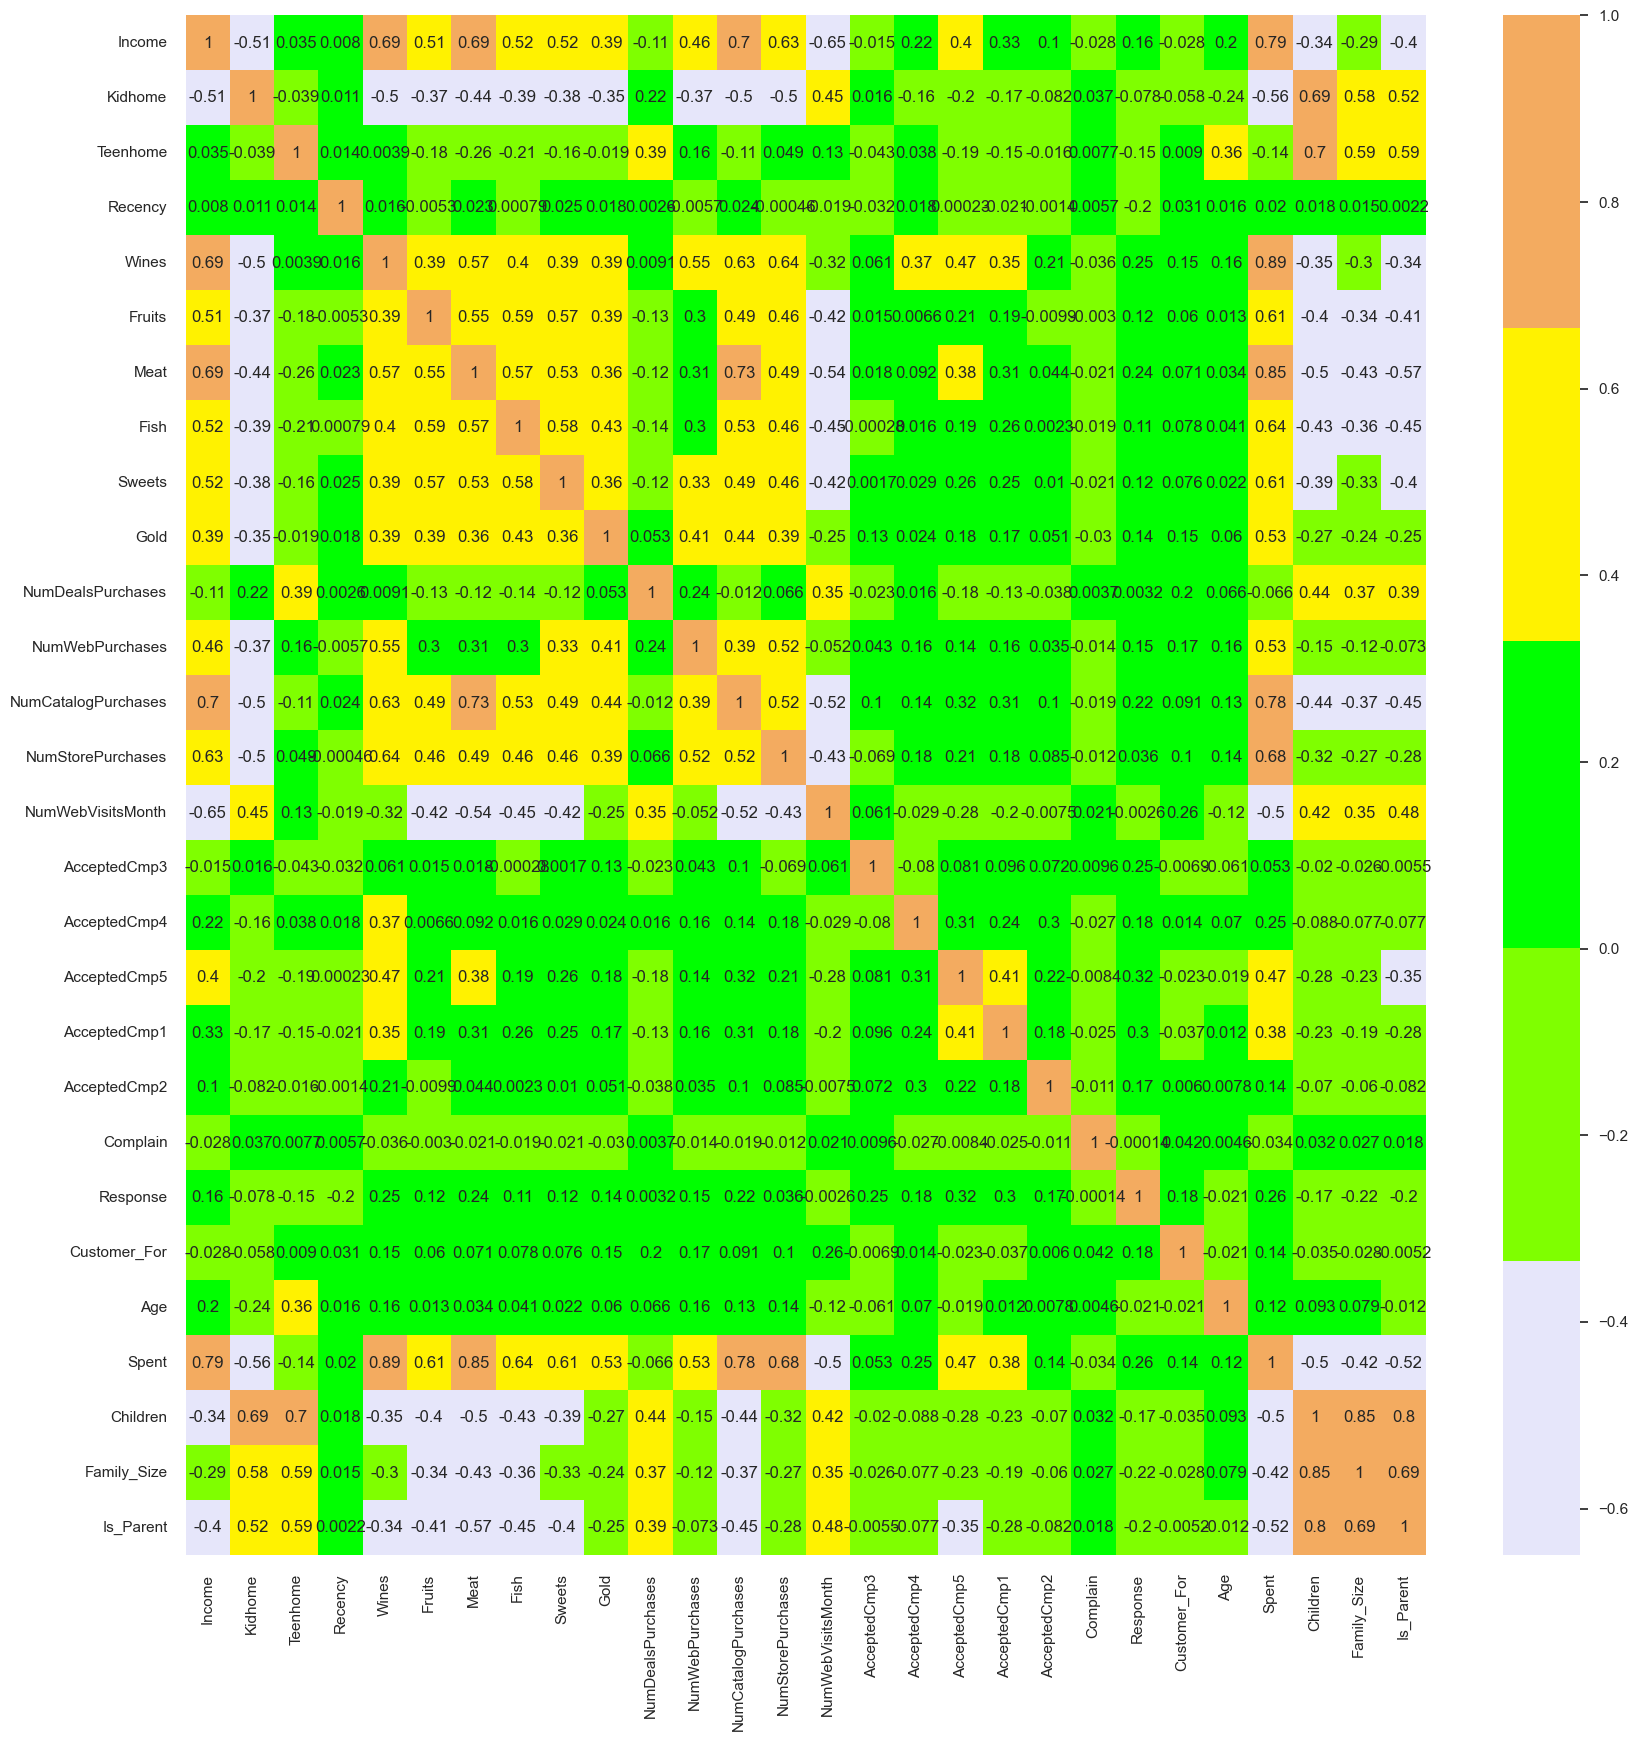

In [19]:
#correlation matrix
corrmat= df.corr()
plt.figure(figsize=(20,20))  
sns.heatmap(corrmat,annot=True, cmap=cmap, center=0)

In [20]:
#Get list of categorical variables
k = (df.dtypes == 'object')
object_cols = list(k[k].index)

print("Categorical variables in the dataset:", object_cols)

Categorical variables in the dataset: ['Education', 'Living_With']


In [21]:
#Label Encoding the object dtypes.
LE=LabelEncoder()
for i in object_cols:
    df[i]=df[[i]].apply(LE.fit_transform)
    
print("All features are now numerical")

All features are now numerical


In [22]:
ds = df.copy()
# creating a subset of dataframe by dropping the features on deals accepted and promotions
cols_del = ['AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1','AcceptedCmp2', 'Complain', 'Response']
ds = ds.drop(cols_del, axis=1)

#Scaling
scaler = StandardScaler()
scaler.fit(ds)

scaled_ds = pd.DataFrame(scaler.transform(ds),columns= ds.columns )
print("All features are now scaled")

All features are now scaled


**DIMENSIONALITY REDUCTION;**

Steps in this section:

Dimensionality reduction with PCA
Plotting the reduced dataframe

# Dimensionality reduction with PCA

In [23]:
#Initiating PCA to reduce dimentions aka features to 3
pca = PCA(n_components=3)
pca.fit(scaled_ds)
PCA_ds = pd.DataFrame(pca.transform(scaled_ds), columns=(["col1","col2", "col3"]))
PCA_ds.describe().T

,count,mean,std,min,25%,50%,75%,max
col1,2212.0,1.465575e-17,2.878377,-5.969394,-2.538494,-0.780421,2.383290,7.444305
col2,2212.0,4.216037e-17,1.706839,-4.312173,-1.328334,-0.158265,1.242258,6.142826
col3,2212.0,2.825748e-17,1.221950,-3.525717,-0.828670,-0.020929,0.800374,6.611154


In [24]:
PCA_ds.describe()

,col1,col2,col3
count,2.212000e+03,2.212000e+03,2.212000e+03
mean,1.465575e-17,4.216037e-17,2.825748e-17
std,2.878377e+00,1.706839e+00,1.221950e+00
min,-5.969394e+00,-4.312173e+00,-3.525717e+00
25%,-2.538494e+00,-1.328334e+00,-8.286696e-01
50%,-7.804210e-01,-1.582649e-01,-2.092880e-02
75%,2.383290e+00,1.242258e+00,8.003741e-01
max,7.444305e+00,6.142826e+00,6.611154e+00


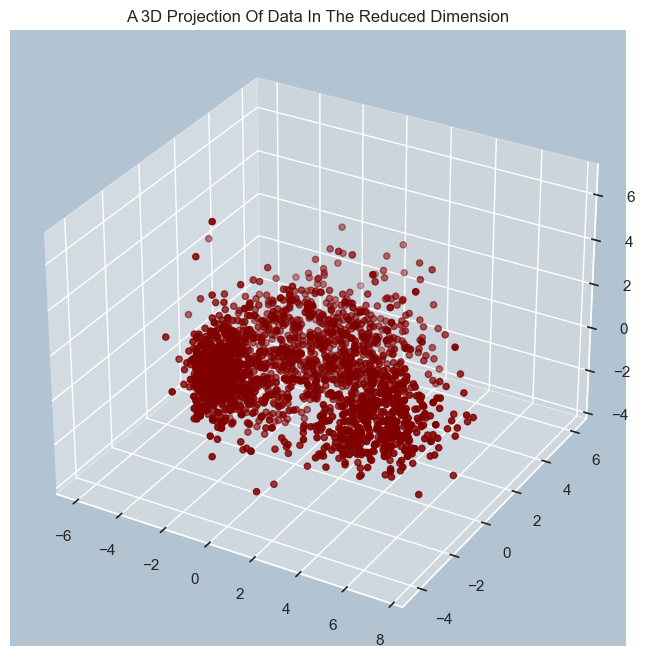

In [25]:
#A 3D Projection Of Data In The Reduced Dimension
x =PCA_ds["col1"]
y =PCA_ds["col2"]
z =PCA_ds["col3"]

#To plot
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(x,y,z, c="maroon", marker="o" )
ax.set_title("A 3D Projection Of Data In The Reduced Dimension")

plt.show()

**Unsupervised Machine Learning**

Steps involved in the Clustering

*    Elbow Method to determine the number of clusters to be formed
*    Clustering via Agglomerative Clustering
*    Examining the clusters formed via scatter plot


Elbow Method to determine the number of clusters to be formed:


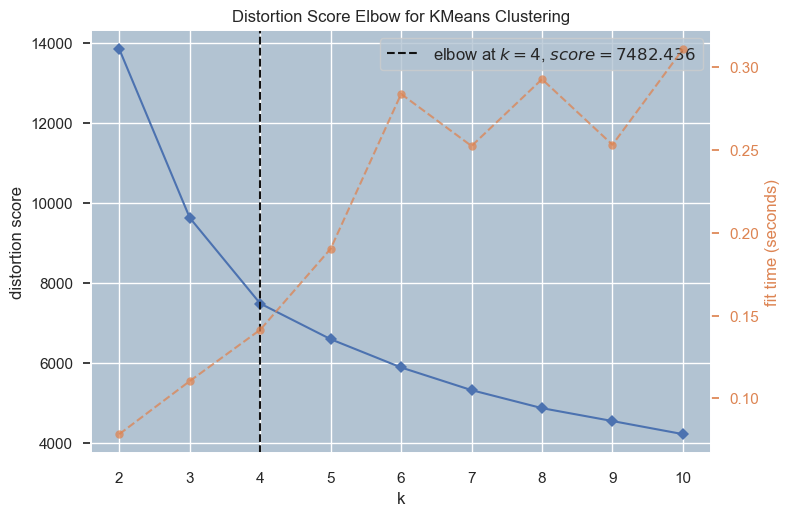

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [26]:
# Quick examination of elbow method to find numbers of clusters to make.
print('Elbow Method to determine the number of clusters to be formed:')
Elbow_M = KElbowVisualizer(KMeans(), k=10)
Elbow_M.fit(PCA_ds)

Elbow_M.show()

In [27]:
#Initiating the Agglomerative Clustering model 
AC = AgglomerativeClustering(n_clusters=4)

# fit model and predict clusters
yhat_AC = AC.fit_predict(PCA_ds)
PCA_ds["Clusters"] = yhat_AC

#Adding the Clusters feature to the orignal dataframe.
df["Clusters"]= yhat_AC

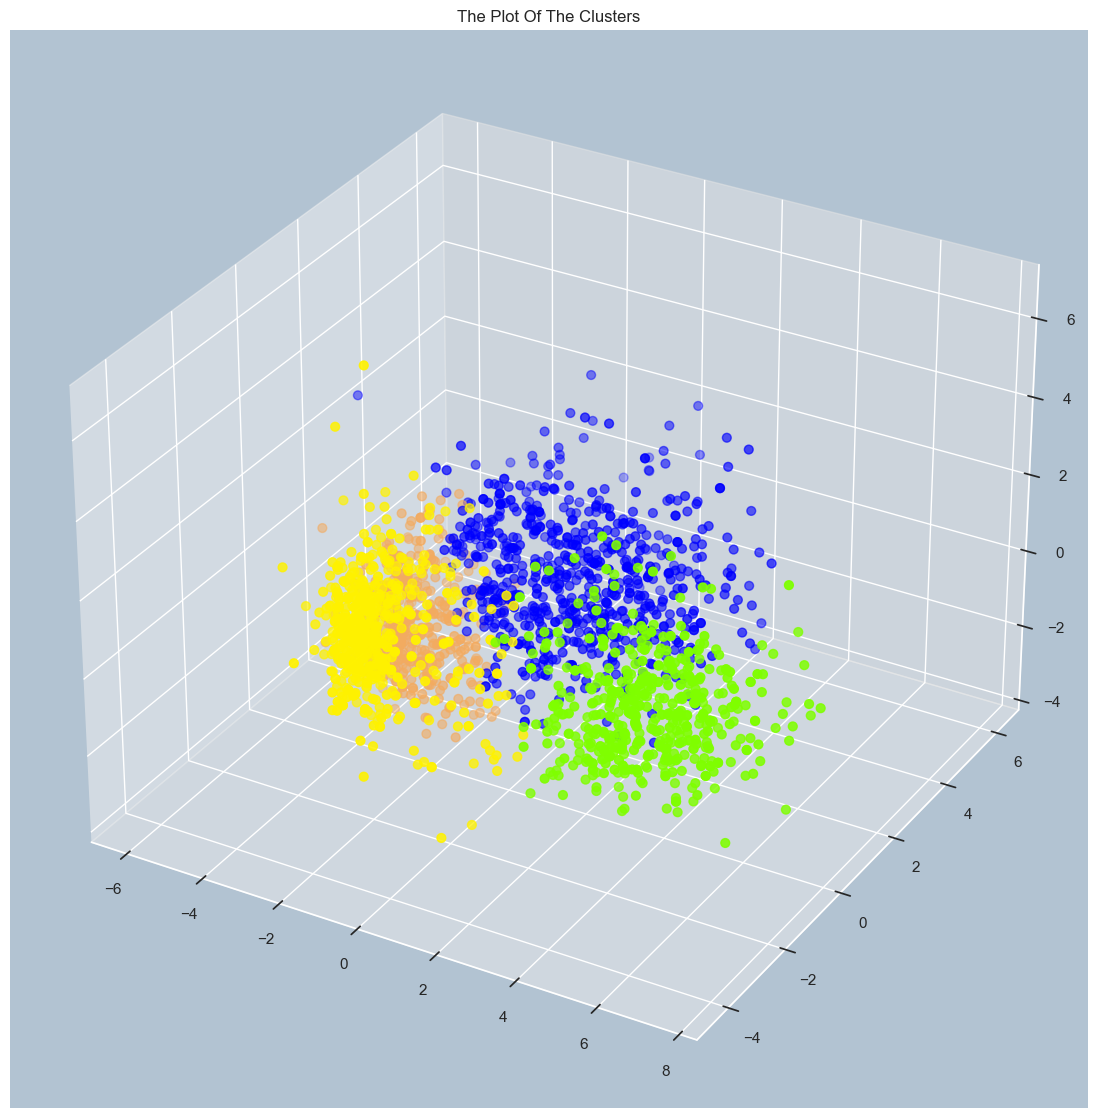

In [28]:
#Plotting the clusters
fig = plt.figure(figsize=(16,14))
ax = plt.subplot(111, projection='3d', label="bla")

ax.scatter(x, y, z, s=40, c=PCA_ds["Clusters"], marker='o', cmap = cmap )
ax.set_title("The Plot Of The Clusters")

plt.show()

# Evaluating Models

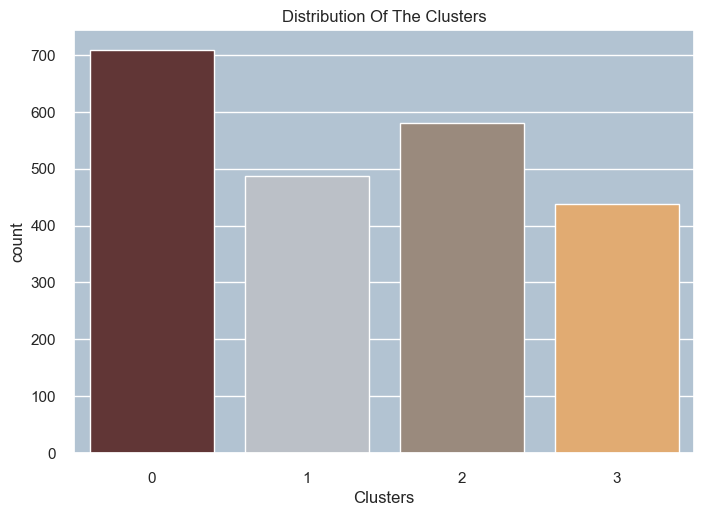

In [29]:
#Plotting countplot of clusters
pal = ["#682F2F","#B9C0C9", "#9F8A78","#F3AB60"]
pl = sns.countplot(x=df["Clusters"], palette= pal)
pl.set_title("Distribution Of The Clusters")
plt.show()

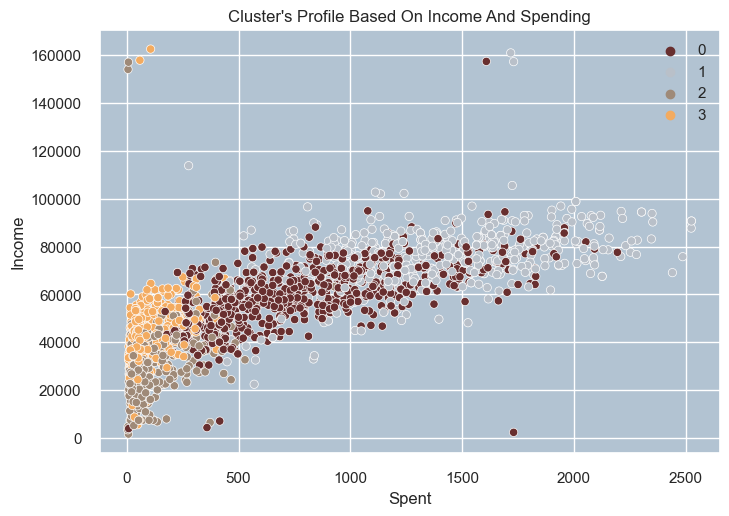

In [30]:
pl = sns.scatterplot(data = df,x=df["Spent"], y=df["Income"],hue=df["Clusters"], palette= pal)
pl.set_title("Cluster's Profile Based On Income And Spending")
plt.legend()
plt.show()

Income vs spending plot shows the clusters pattern

group 0: high spending & average income

group 1: high spending & high income

group 2: low spending & low income

group 3: high spending & low income

Next, I will be looking at the detailed distribution of clusters as per the various products in the data. Namely: Wines, Fruits, Meat, Fish, Sweets and Gold

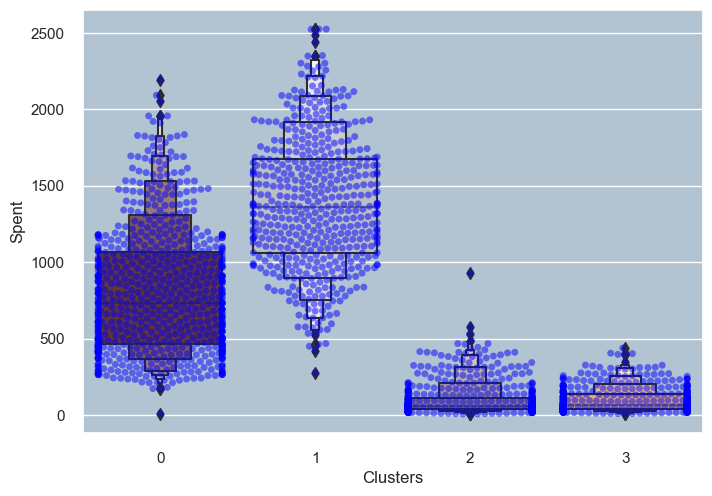

In [31]:
plt.figure()
pl=sns.swarmplot(x=df["Clusters"], y=df["Spent"], color= "#0000FF", alpha=0.5 )
pl=sns.boxenplot(x=df["Clusters"], y=df["Spent"], palette=pal)
plt.show()
#["#0000FF","#FF0090"]#CBEDDD

From the above plot, it can be clearly seen that cluster 1 is our biggest set of customers closely followed by cluster 0. We can explore what each cluster is spending on for the targeted marketing strategies.

Let us next explore how did our campaigns do in the past.

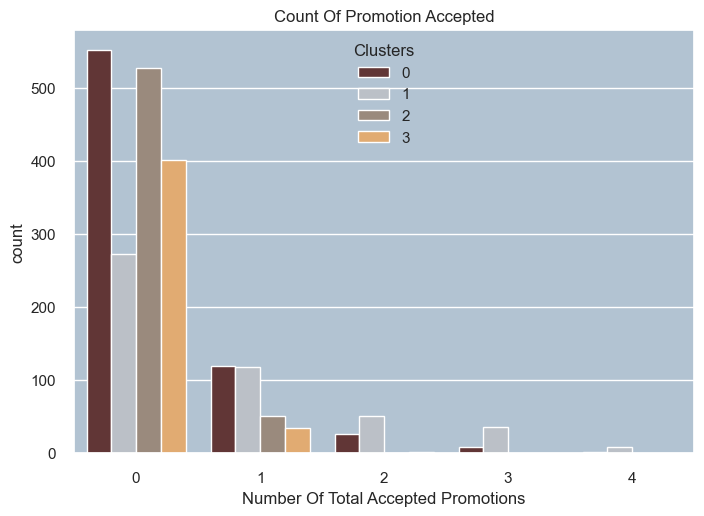

In [32]:
#Creating a feature to get a sum of accepted promotions 
df["Total_Promos"] = df["AcceptedCmp1"]+ df["AcceptedCmp2"]+ df["AcceptedCmp3"]+ df["AcceptedCmp4"]+ df["AcceptedCmp5"]
#Plotting count of total campaign accepted.
plt.figure()
pl = sns.countplot(x=df["Total_Promos"],hue=df["Clusters"], palette= pal)
pl.set_title("Count Of Promotion Accepted")
pl.set_xlabel("Number Of Total Accepted Promotions")
plt.show()

There has not been an overwhelming response to the campaigns so far. Very few participants overall. Moreover, no one part take in all 5 of them. Perhaps better-targeted and well-planned campaigns are required to boost sales.

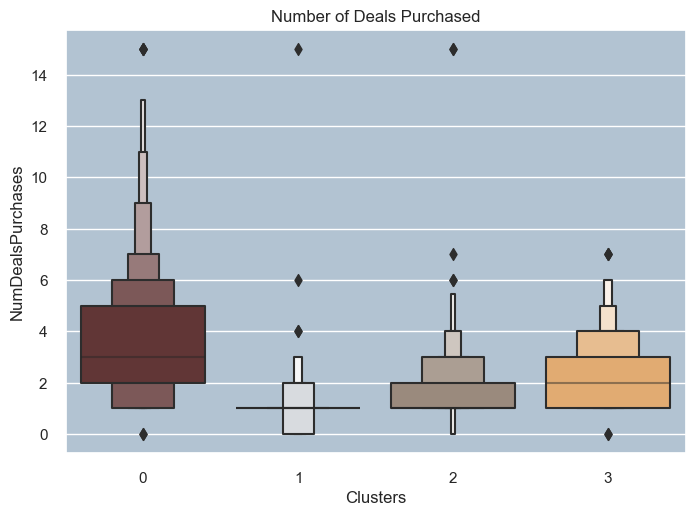

In [33]:
#Plotting the number of deals purchased
plt.figure()
pl=sns.boxenplot(y=df["NumDealsPurchases"],x=df["Clusters"], palette= pal)
pl.set_title("Number of Deals Purchased")
plt.show()

Unlike campaigns, the deals offered did well. It has best outcome with cluster 0 and cluster 3. 
However, our star customers cluster 1 are not much into the deals. 
Nothing seems to attract cluster 2 overwhelmingly 


# Targating

Now that we have formed the clusters and looked at their purchasing habits. Let us see who all are there in these clusters. For that, we will be profiling the clusters formed and come to a conclusion about who is our star customer and who needs more attention from the retail store's marketing team.

To decide that I will be plotting some of the features that are indicative of the customer's personal traits in light of the cluster they are in. On the basis of the outcomes, I will be arriving at the conclusions.

<Figure size 800x550 with 0 Axes>

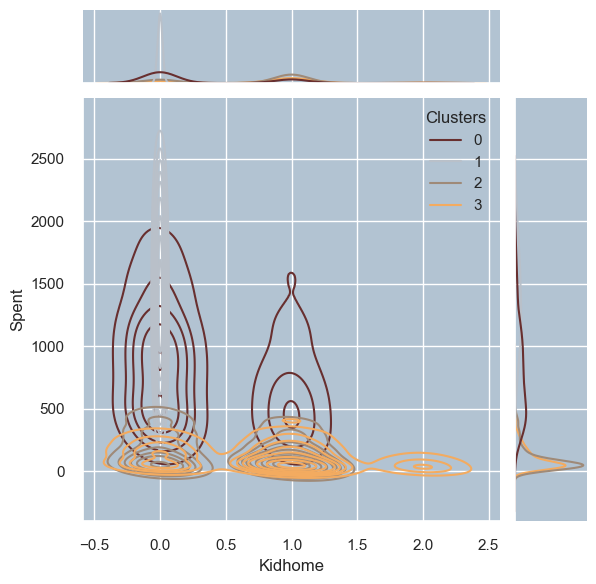

<Figure size 800x550 with 0 Axes>

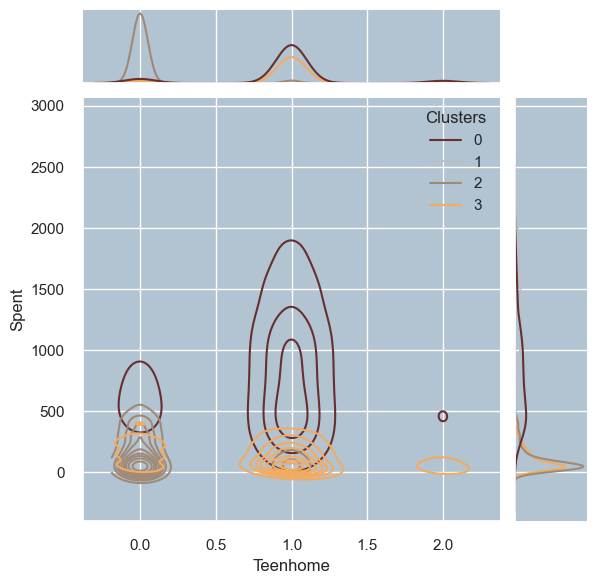

<Figure size 800x550 with 0 Axes>

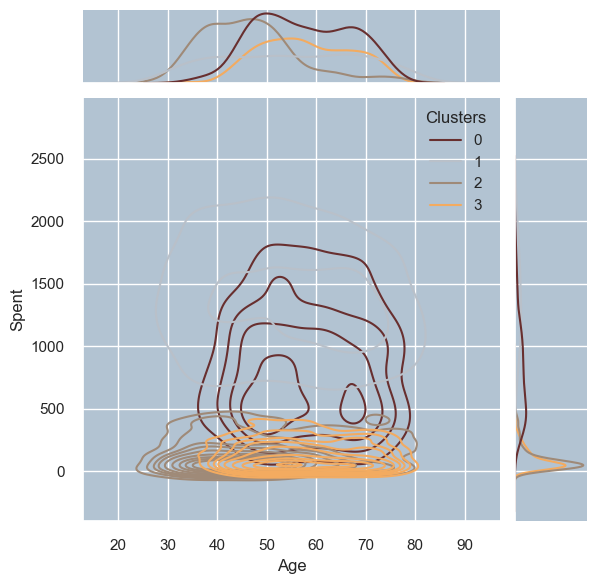

<Figure size 800x550 with 0 Axes>

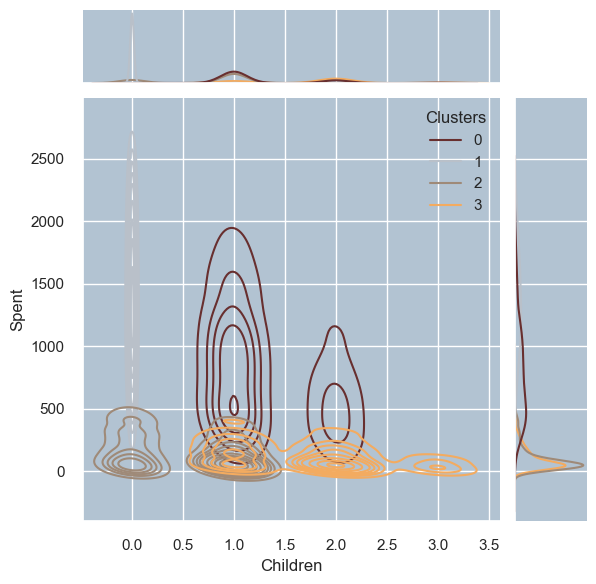

<Figure size 800x550 with 0 Axes>

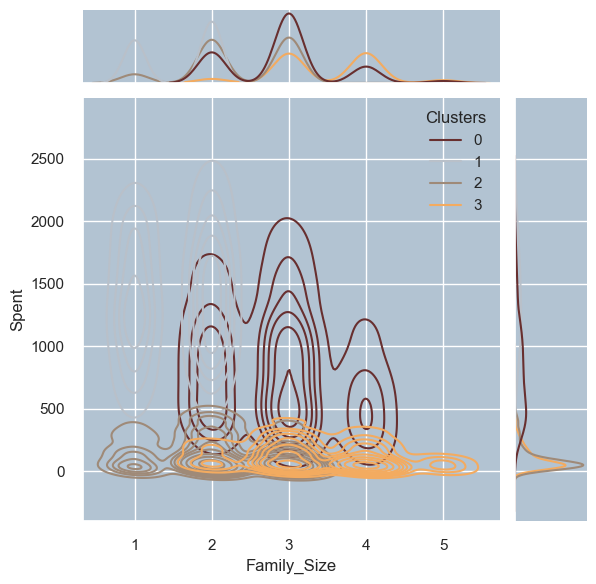

<Figure size 800x550 with 0 Axes>

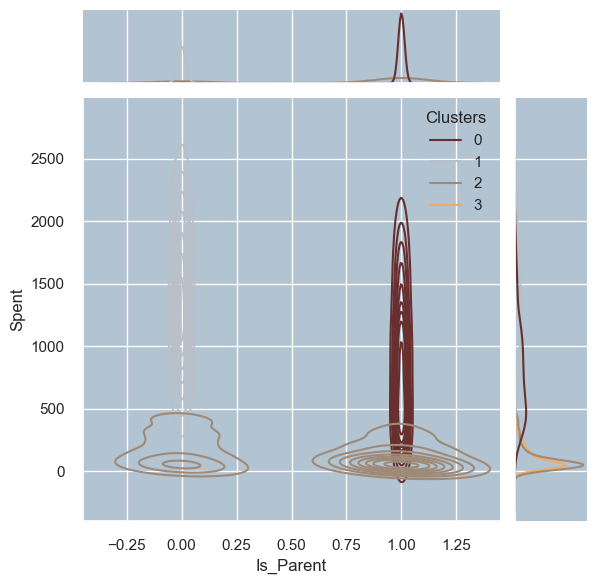

<Figure size 800x550 with 0 Axes>

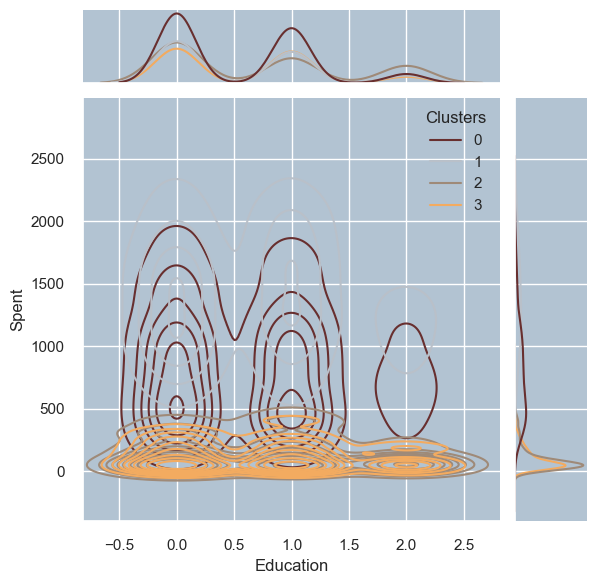

<Figure size 800x550 with 0 Axes>

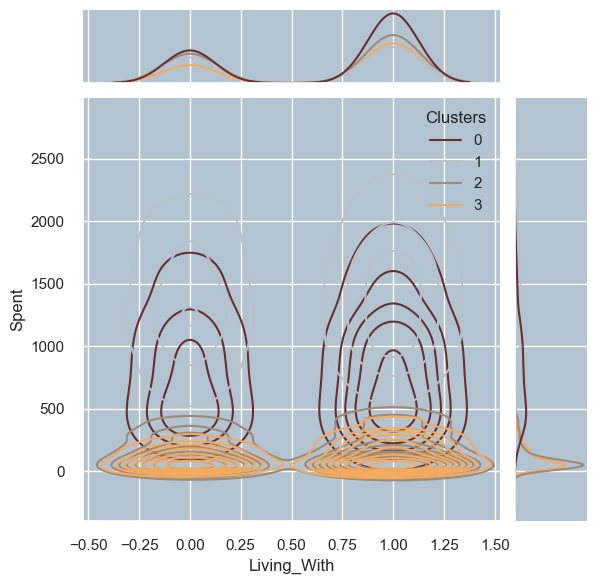

In [34]:
Personal = [ "Kidhome","Teenhome", "Age", "Children", "Family_Size", "Is_Parent", "Education","Living_With"]

for i in Personal:
    plt.figure()
    sns.jointplot(x=df[i], y=df["Spent"], hue =df["Clusters"], kind="kde", palette=pal)
    plt.show()

# Positioning

POSITIONING

based on your clustering and targeting results, we can positioning a strategy like this:

Cluster 0 (high spending & average income): "Luxury for less".

Cluster 1 (high spending & high income): "Ultimate luxury".

Cluster 2 (low spending & low income): "Affordable products".

Cluster 3 (high spending & low income): "Affordable luxury"

In [35]:
# Define the value position for each group of customers
value_positions = {
    0: "Luxury for less",
    1: "Exclusive luxury",
    2: "Affordable fashion",
    3: "Affordable luxury"
}

# Add a new column to the DataFrame with the value position for each customer based on their cluster
df['Value_Proposition'] = df['Clusters'].map(value_positions)
df['Value_Proposition'].head()

0      Exclusive luxury
1     Affordable luxury
2      Exclusive luxury
3    Affordable fashion
4       Luxury for less
Name: Value_Proposition, dtype: object

CONCLUSION

In this project, I performed unsupervised clustering. I did use dimensionality reduction followed by agglomerative clustering. I came up with 4 clusters and further used them in targeting customers in clusters according to their family structures and income/spending. This can be used in planning better marketing strategies like positioning strategy which I made.